# Import

In [1]:
from interpret import *
from tint.metrics import mse, mae
import tint, captum, gc
from tqdm import tqdm
import pandas as pd
from utils.explainer import *
from exp.exp_interpret import *
from utils.tools import normalize_scale

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils.plot_config import *
%matplotlib inline

# Util

In [2]:
from data.uea import collate_fn

def prepare_input(
    data, device, args
):
    if args.task_name == 'classification':
        batch_x, batch_y, padding_mask = data
        batch_x = batch_x.float().to(device)
        batch_y= batch_y.float().to(device)
        padding_mask = padding_mask.float().to(device)
        
        inputs = batch_x
        additional_forward_args = (padding_mask, None, None)
    else:
        batch_x, batch_y, batch_x_mark, batch_y_mark = data
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()
        
        inputs = (batch_x, batch_x_mark)
        additional_forward_args = (dec_inp, batch_y_mark)
    
    return (inputs, additional_forward_args, batch_y)

def prepare_from_dataset(data, device, args):
    if args.task_name == 'classification':
        # already converted to tensor from numpy
        batch_x, batch_y, padding_mask = collate_fn(data)
        batch_x = batch_x.float().to(device)
        batch_y= batch_y.float().to(device)
        padding_mask = padding_mask.float().to(device)
        
        inputs = batch_x
        additional_forward_args = (padding_mask, None, None)
    else:
        batch_x, batch_y, batch_x_mark, batch_y_mark = [
            torch.stack(
                [
                    torch.tensor(d[i], dtype=float, device=device) 
                    for d in data
                ]
            ) 
            for i in range(4)
        ]
        batch_x = torch.tensor(batch_x).float().to(device)
        batch_y = torch.tensor(batch_y).float().to(device)

        batch_x_mark = torch.tensor(batch_x_mark).float().to(device)
        batch_y_mark = torch.tensor(batch_y_mark).float().to(device)
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()
        
        inputs = (batch_x, batch_x_mark)
        additional_forward_args = (dec_inp, batch_y_mark)
    
    return (inputs, additional_forward_args, batch_y)

# Arguments

In [3]:
parser = get_parser()

argv = """
  --explainers wtsr winIT tsr feature_ablation augmented_occlusion   \
  --task_name classification \
  --data mimic \
  --itr_no 1 --seq_len 48\
  --root_path ./dataset/mimic_iii/ \
  --data_path mimic_iii.pkl \
  --metrics auc accuracy cross_entropy \
  --model iTransformer --n_features 31
""".split()

# argv = """
#   --task_name long_term_forecast \
#   --explainers wtsr winIT tsr feature_ablation augmented_occlusion\
#   --root_path ./dataset/electricity/ \
#   --data_path electricity.csv \
#   --model iTransformer \
#   --itr_no 1 \
#   --features S \
#   --seq_len 96 \
#   --label_len 12 \
#   --pred_len 24 \
#   --n_features 1
# """.split()

args = parser.parse_args(argv)

# only evaluate on test
args.flag = 'test'
# Disable cudnn if using cuda accelerator.
# Please see https://captum.ai/docs/faq#how-can-i-resolve-cudnn-rnn-backward-error-for-rnn-or-lstm-network
# args.use_gpu = False
initial_setup(args)

# Initialize

## Experiment

In [4]:
if args.task_name == 'classification': Exp = Exp_Classification
else: Exp = Exp_Long_Term_Forecast
exp = Exp(args)  # set experiments

# should be test or validation data
dataset, dataloader = exp._get_data(args.flag)
exp.load_best_model()

model = exp.model
_ = model.eval()
# model.zero_grad()

Use GPU: cuda:0
Dead patients 1832, percentage 9.96.
train 18390
Dead patients 229, percentage 9.96.
test 2299
Experiments will be saved in ./results\mimic_iii_iTransformer\1
Dead patients 229, percentage 9.96.
test 2299
Loading model from ./results\mimic_iii_iTransformer\1\checkpoint.pth


In [5]:
n_samples = 3
example_no =[]

if args.data_path == 'mimic_iii.pkl':
    for i in range(len(dataset)):
        if dataset[i][1].item() == 1:
            example_no.append(i)
            n_samples -=1

        if n_samples <= 0: break
        
    if len(example_no) < n_samples:
        raise Exception(f'Not enough samples')
else:
    example_no = np.random.randint(0, len(dataset)-1, n_samples)
    print(f'Randomly chosen {example_no}')

## Explainer

In [6]:
from exp.exp_interpret import Exp_Interpret

explainers_map = dict() 
for name in exp.args.explainers:
    explainer = Exp_Interpret.initialize_explainer(
        name, exp.model, exp.args, exp.device, dataloader
    ) 
    explainers_map[name] = explainer

# Input

In [7]:
# inputs, additional_forward_args, labels = prepare_input(
#     next(iter(dataloader)), exp.device, args
# )
if args.task_name == 'classification':
    inputs, additional_forward_args, labels = prepare_from_dataset(
        [dataset[i] for i in example_no], exp.device, args
    )
else: 
    inputs, additional_forward_args, labels = prepare_from_dataset(
        [dataset[i] for i in example_no], exp.device, args
    )
baselines = get_baseline(inputs, args.baseline_mode)

# Interpret

## Explainer

In [8]:
# explainer = FeatureAblation(model)
# explainer = explainers_map[name]
attr_map = dict()

for name in exp.args.explainers:
    print(name)
    explainer = explainers_map[name]
    attr = compute_attr(
        name, inputs, baselines, explainer, 
        additional_forward_args, args
    )
        
    if args.task_name == 'classification':
        attr_numpy = attr.detach().cpu().numpy()
    else:
        attr_numpy = tuple([a.detach().cpu().numpy() for a in attr])

    attr_map[name] = attr_numpy

wtsr
winIT
tsr
feature_ablation
augmented_occlusion


# Visualization

In [9]:
sample_no = 0
if args.data_path == 'mimic_iii.pkl': target = 1
else: target = 0
cmap='binary' # binary, RdYlGn, grey, hot

In [10]:
if args.data_path == 'mimic_iii.pkl':
    vital_IDs = ['HeartRate' , 'SysBP' , 'DiasBP' , 'MeanBP' , 'RespRate' , 'SpO2' , 'Glucose' ,'Temp']
    others = ['gender', 'age', 'ethnicity', 'first_icu_stay']
    lab_IDs = [
        'ANION GAP', 'ALBUMIN', 'BICARBONATE', 'BILIRUBIN', 
        'CREATININE', 'CHLORIDE', 'GLUCOSE', 'HEMATOCRIT', 
        # 'HEMOGLOBIN' 'LACTATE' -> 'HEMOGLOBIN', 'LACTATE'. But the source preprocessing uses it like this
        'HEMOGLOBIN' 'LACTATE', 'MAGNESIUM', 'PHOSPHATE', 
        'PLATELET', 'POTASSIUM', 'PTT', 'INR', 
        'PT', 'SODIUM', 'BUN', 'WBC'
    ]
    features = vital_IDs + others + lab_IDs # feature
elif args.data_path == 'electricity.csv':
    features = ['Electricity', 'Hour', 'Weekday', 'Day', 'Month']
elif args.data_path == 'traffic.csv':
    features = ['Traffic', 'Hour', 'Weekday', 'Day', 'Month']
else:
    raise ValueError(f'Data path {args.data_path} not implemented yet')

## All features

In [11]:
def numpy_min_max(data, axis=-1):
    return (data - data.min(axis=axis, keepdims=True)) / (data.max(axis=axis, keepdims=True) - data.min(axis=axis, keepdims=True))

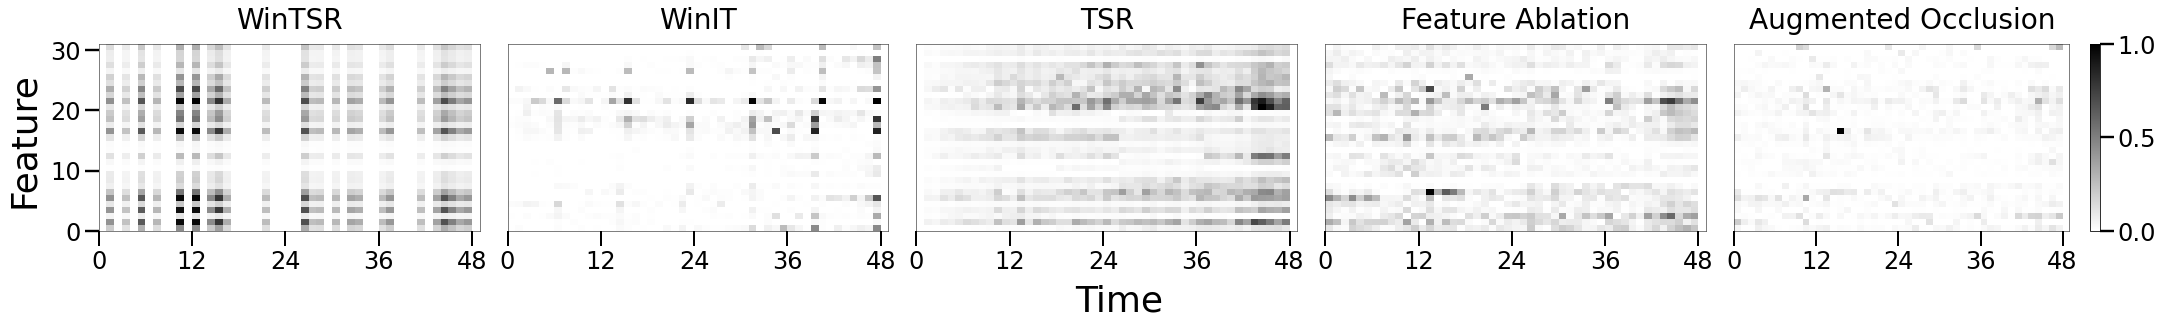

In [12]:
n = len(args.explainers)
rows, columns = 1, n
width_ratios=  [1] * (n-1) + [1.1]

if args.data_path == 'mimic_iii.pkl':
    fig, axes = plt.subplots(rows, columns, figsize =(30, 4), width_ratios=width_ratios)
else:
    fig, axes = plt.subplots(rows, columns, figsize =(30, 4), width_ratios=width_ratios)

for row in range(rows):
    for col in range(columns):
        explainer_no = row * columns + col
        name = args.explainers[explainer_no]
        attr_normed = attr_map[name]
        if type(attr_normed) == tuple:
            # concatenate across feature dimension
            # attr_normed = tuple([numpy_min_max(a, axis=(-2, -1))  for a in attr_normed])
            attr_normed = np.concatenate(attr_normed, axis=-1)
            
            # only use the encoder features
            # attr_normed = attr_normed[0]
            
        attr_normed = numpy_min_max(attr_normed, axis=(-2, -1))
        if rows == 1: 
            if columns == 1: ax = axes
            else: ax = axes[col]
        else: 
            if columns == 1: ax = axes[row]
            else: ax = axes[row][col]
            
        # if only one feature
        if attr_normed.shape[-1] == 1:
            if target is None:
                ax.plot(attr_normed[sample_no].mean(axis=0).T[0])
            else:    
                ax.plot(attr_normed[sample_no, target].T[0])
        else:
            if target is None:
                psm = ax.pcolormesh(
                    attr_normed[sample_no].mean(axis=0).T,
                    cmap=cmap, # vmax=1 # rasterized=True
                )
            else:
                psm = ax.pcolormesh(
                    attr_normed[sample_no, target].T,
                    cmap=cmap, # vmax=1 # rasterized=True
                )
            # colorbar at the rightmost column
            if col + 1 == columns:
                fig.colorbar(psm, ax=ax)
        
        
        # make the axes more visible
        plt.setp(ax.spines.values(), linewidth=0.5) 
        if col > 0:
            ax.get_yaxis().set_visible(False)   
        
        # im = axes[0].imshow(attr_normed[example_no, target].T, cmap='binary', interpolation='nearest')
        # axes[0].figure.colorbar(im, fraction=0.03, pad=0.04)
        # name = explainer_name_map[]
        name = explainer_name_map[name].get_name()
        ax.set_title(name, fontsize=28)
        if args.data_path == 'mimic_iii.pkl':
            ax.xaxis.set_major_locator(MultipleLocator(base=12))
            ax.yaxis.set_major_locator(MultipleLocator(base=10))
        else:
            ax.xaxis.set_major_locator(MultipleLocator(base=24))
            if attr_normed.shape[-1] < 6:
                ax.yaxis.set_major_locator(MultipleLocator(base=1))
        ax.set_xlim(0, ax.get_xlim()[1]+1)

fig.tight_layout()
fig.supylabel('Feature', fontsize=36, x=-.015)
fig.supxlabel('Time', fontsize=36, y=-0.12)
# plt.suptitle('Heat map of feature importance scores')
# plt.savefig(f'{exp.output_folder}/heatmap_{example_no[sample_no]}_normed.jpg', dpi=200, bbox_inches="tight")
plt.show()

## Raw input

In [13]:
if type(inputs) == tuple:
    X = torch.concat(inputs, dim=-1).detach().cpu().numpy()
else:
    X = inputs.detach().cpu().numpy()
    
features[attr_normed[sample_no, target].sum(axis=-2).argmax()]

'MAGNESIUM'

### Colormesh

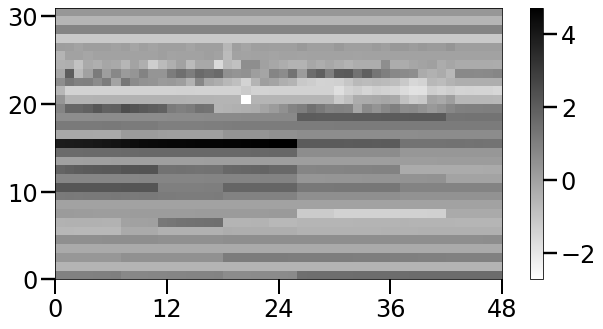

In [14]:
fig, ax = plt.subplots(1, 1, figsize =(10, 5))
psm = ax.pcolormesh(
    X[sample_no].T, 
    cmap=cmap, # vmin=0, vmax=1 # rasterized=True
)
fig.colorbar(psm, ax=ax)

if args.data_path != 'mimic_iii.pkl':
    ax.yaxis.set_major_locator(MultipleLocator(base=1))
    ax.set_yticks([i+ 0.5 for i in range(len(features))], labels=features)
    
    ax.xaxis.set_major_locator(MultipleLocator(base=24))
else:
    ax.yaxis.set_major_locator(MultipleLocator(base=10))
    ax.xaxis.set_major_locator(MultipleLocator(base=12))

# plt.savefig(f'{exp.output_folder}/example_{example_no[sample_no]}.jpg', dpi=200, bbox_inches="tight")
plt.show()

### Lineplot

In [15]:
# https://stackoverflow.com/questions/34933905/adding-subplots-to-a-subplot
if args.data_path != 'mimic_iii.pkl':
    fig, axes = plt.subplots(X.shape[-1], 1, figsize =(7, 4), sharex=True)
    for i, ax in enumerate(axes):
        if i + 1 < len(axes): 
            ax.get_xaxis().set_visible(False)
            ax.spines['bottom'].set_color('white')
        if i>0:
            ax.spines['top'].set_color('white')
        
        # ax.get_yaxis().label.set_visible(False)
        # ax.get_yaxis().set_visible(False)
        ax.set_yticks([])
        
        feature_no = X.shape[-1]-i-1
        ax.plot(X[sample_no, :, feature_no], color='black', linewidth=1.5)
        ax.set_ylabel(features[feature_no], rotation=0.45, labelpad=70, y=.3)
        ax.xaxis.set_major_locator(MultipleLocator(base=24))

    fig.supxlabel('Time', fontsize=34, y=-0.15)
    # plt.savefig(f'{exp.output_folder}/example_{example_no[sample_no]}_2.jpg', dpi=200, bbox_inches="tight")
    plt.subplots_adjust(hspace=0)
    plt.show()

## Gridspec

In [16]:
plt.rcParams['lines.linewidth'] = 1

In [17]:
if args.data_path != 'mimic_iii.pkl':
    fig = plt.figure(figsize=(44, 4))
    # each row will plot one feature
    # first column for raw input, rest for the explainers
    rows, columns = len(features), len(args.explainers) + 1

    # https://stackoverflow.com/questions/34933905/adding-subplots-to-a-subplot
    outer = gridspec.GridSpec(1, columns, wspace=0.1, hspace=0.1)

    for i in range(columns):
        inner = gridspec.GridSpecFromSubplotSpec(
            rows, 1, subplot_spec=outer[i], wspace=0.1, hspace=0
        )
        
        for j in range(rows):
            ax = plt.Subplot(fig, inner[j])
            feature_no = X.shape[-1]-j-1
            if j + 1 < rows: 
                ax.get_xaxis().set_visible(False)
                # ax.spines['bottom'].set_color('white')
                # ax.set_xticks([])
            ax.set_yticks([])
            
            # draw the raw input features
            if i == 0:
                if j ==0:
                    ax.set_title('Raw input', y=1.05)

                ax.plot(X[sample_no, :, feature_no], color='black', linewidth=1.5)
                ax.set_ylabel(features[feature_no], rotation=0.45, labelpad=70, y=.3)
                
                ax.xaxis.set_major_locator(MultipleLocator(base=24))
                fig.add_subplot(ax)
                continue
            
            explainer_no = i - 1
            name = args.explainers[explainer_no]
            attr_normed = attr_map[name]
            if j ==0: ax.set_title(explainer_name_map[name].get_name(), y=1.05)
            if type(attr_normed) == tuple:
                # concatenate across feature dimension
                # attr_normed = tuple([numpy_min_max(a, axis=(-2, -1))  for a in attr_normed])
                attr_normed = np.concatenate(attr_normed, axis=-1)
                
            attr_normed = numpy_min_max(attr_normed, axis=(-2, -1))
            if target is None:
                ax.plot(attr_normed[sample_no].mean(axis=0).T[feature_no], color='black')
            else:    
                ax.plot(attr_normed[sample_no, target].T[feature_no], color='black')
            ax.xaxis.set_major_locator(MultipleLocator(base=24))
            
            # t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
            # t.set_ha('center')
            # ax.set_xticks([])
            
            # the last column
            if i + 1 == columns and j == 0:
                ax.set_ylabel('Relevance Score, φ(X)')
                ax.get_yaxis().set_label_coords(1.12,-1.5)
            fig.add_subplot(ax)
            
    fig.supxlabel('Time (hour)', y=-0.15, fontsize=36)
    # plt.savefig(f'{exp.output_folder}/heatmap_{example_no[sample_no]}_normed.png', dpi=100, bbox_inches="tight")
    plt.show()

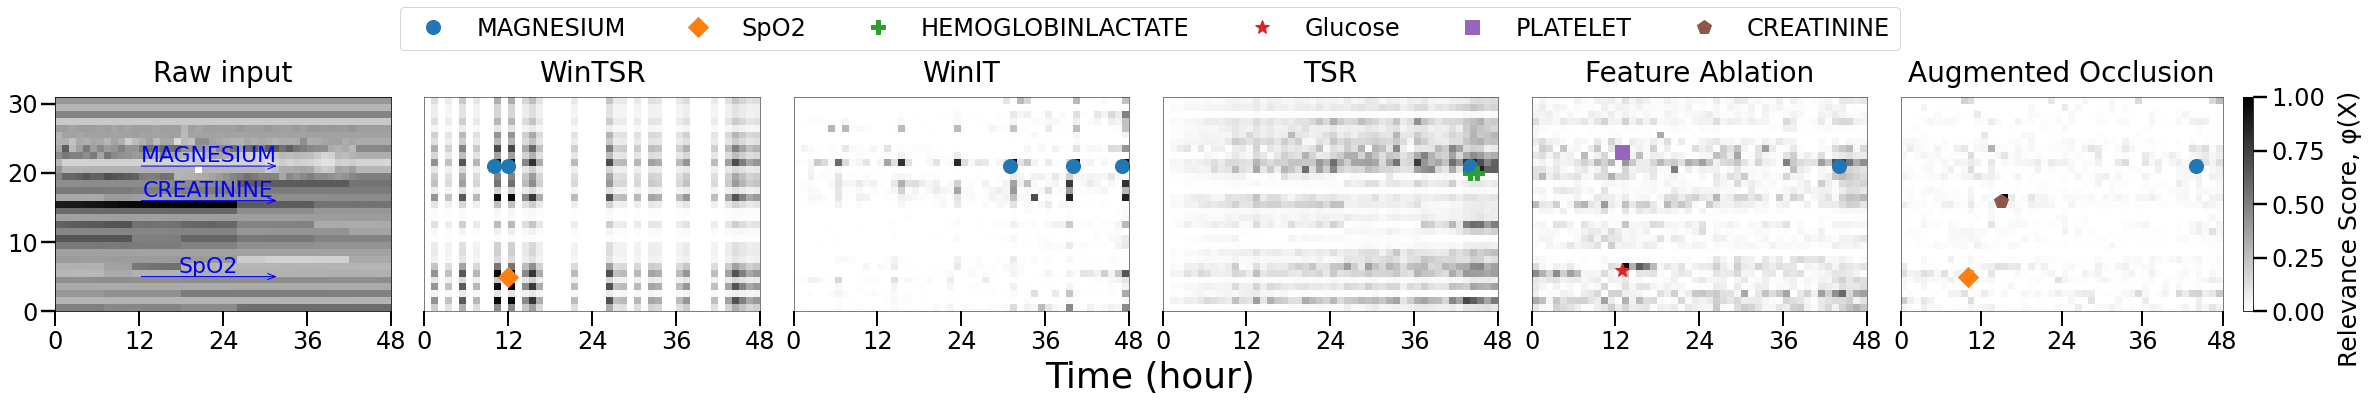

In [51]:
import matplotlib.patches as mpatches

color_dict = {}
marker_index = 0
legend_labels, legend_handles = [], []
prop_cycle = iter(plt.rcParams["axes.prop_cycle"])

# colormap is only supported for MIMIC-III
if args.data_path == 'mimic_iii.pkl':
    n = len(args.explainers)
    columns = n + 1
    width_ratios=  [1] * (n) + [1.2]

    fig, axes = plt.subplots(1, columns, figsize =(33, 5), width_ratios=width_ratios)

    for col in range(columns):
        ax = axes[col]
        if col == 0:
            psm = ax.pcolormesh(
                X[sample_no].T, 
                cmap=cmap, # vmin=0, vmax=1 # rasterized=True
            )
            # fig.colorbar(psm, ax=ax)
            ax.yaxis.set_major_locator(MultipleLocator(base=10))
            ax.xaxis.set_major_locator(MultipleLocator(base=12))
            ax.set_title('Raw input')

            color = 'blue'
            for j in [5, 16, 21]:
                arr = mpatches.FancyArrowPatch(
                    (12, j), (32, j), arrowstyle='->,head_width=.15', 
                    mutation_scale=20, color=color
                )
                ax.add_patch(arr)
                
                ax.annotate(
                    features[j], (0.5, 0.5), xycoords=arr, ha='center', 
                    va='bottom',fontsize=22, color=color
                )
            continue
        
        name = args.explainers[col - 1]
        attr_normed = attr_map[name]
        if type(attr_normed) == tuple:
            # concatenate across feature dimension
            # attr_normed = tuple([numpy_min_max(a, axis=(-2, -1))  for a in attr_normed])
            attr_normed = np.concatenate(attr_normed, axis=-1)
            # only use the encoder features
            # attr_normed = attr_normed[0]
            
        attr_normed = numpy_min_max(attr_normed, axis=(-2, -1))
        # if only one feature
        if attr_normed.shape[-1] == 1:
            if target is None:
                ax.plot(attr_normed[sample_no].mean(axis=0).T[0])
            else:    
                ax.plot(attr_normed[sample_no, target].T[0])
        else:
            if target is None:
                psm = ax.pcolormesh(
                    attr_normed[sample_no].mean(axis=0).T,
                    cmap=cmap, # vmax=1 # rasterized=True
                )
            else:
                psm = ax.pcolormesh(
                    attr_normed[sample_no, target].T,
                    cmap=cmap, # vmax=1 # rasterized=True
                )
            # colorbar at the rightmost column
            if col + 1 == columns:
                fig.colorbar(psm, ax=ax)
        
        
        # make the axes more visible
        plt.setp(ax.spines.values(), linewidth=0.5) 
        if col > 0:
            ax.get_yaxis().set_visible(False)   
        
        # im = axes[0].imshow(attr_normed[example_no, target].T, cmap='binary', interpolation='nearest')
        # axes[0].figure.colorbar(im, fraction=0.03, pad=0.04)
        # name = explainer_name_map[]
        name = explainer_name_map[name].get_name()
        ax.set_title(name, fontsize=28)
        ax.xaxis.set_major_locator(MultipleLocator(base=12))
        ax.yaxis.set_major_locator(MultipleLocator(base=10))
        # ax.set_xlim(0, ax.get_xlim()[1]+1)
        
        # most important feature and time 
        # i, j = np.unravel_index(attr_normed[sample_no, target].argmax(), attr_normed[sample_no, target].shape)
        # j = 21 # attr_normed[sample_no, target].sum(axis=-2).argmax()
        # i = attr_normed[sample_no, target, :, j].argmax()

        # ax.annotate(
        #     features[j], xy=(i, j), xytext=(i-5, j-5), va='top', ha='center',
        #     fontsize=20, color=color,
        #     arrowprops=dict(facecolor='black', arrowstyle='->', lw=3, color=color)
        # )
        
        count = 0
        rows, cols = np.unravel_index(np.argsort(attr_normed[sample_no, target].ravel()), attr_normed[sample_no, target].shape)
        rows,cols = rows[::-1], cols[::-1]
        index = 0
        
        for (i, j) in zip(rows, cols):
            # ax.annotate(
            #     features[j], xy=(i, j), xytext=(i-5, j-5), va='top', ha='center',
            #     fontsize=20, color=color,
            #     arrowprops=dict(facecolor='black', arrowstyle='->', lw=3, color=color)
            # )
            # if index > 0 and (j == cols[index-1] or i == rows[index-1]): continue
            feature = features[j]
            first_time = feature not in color_dict
            if first_time:
                color_dict[feature] = (next(prop_cycle)["color"], marker_index)
                marker_index += 1
            
            color, k = color_dict[feature]
            if first_time:    
                ax.plot(
                    i, j, markers[k], markersize=14, color=color, 
                    # label=f'{feature}, {i+1}h: {attr_normed[sample_no, target, i, j]:.2f}'
                    label=feature if first_time else None
                )
            else:
                ax.plot(
                    i, j, markers[k], markersize=14, color=color
                )

            if index == 2: break
            index += 1
            
        # ax.legend(fontsize=14, ncols=1, loc='best')
        legend_handle, legend_label = ax.get_legend_handles_labels()
        legend_handles.extend(legend_handle)
        legend_labels.extend(legend_label)
        
    # plt.figlegend(legend_handles, legend_labels, loc = (0.2, .96), ncol=6, labelspacing=0.)
    fig.legend(legend_handles, legend_labels, loc='upper center', ncol=len(legend_handles), bbox_to_anchor=(0.5, 1.15),)
    # fig.supylabel('Feature', fontsize=36, x=-.015)
    fig.supxlabel('Time (hour)', fontsize=36, y=0.04)
    fig.supylabel('Relevance Score, φ(X)', fontsize=25, x=1)
    fig.tight_layout()
    # plt.suptitle('Heat map of feature importance scores')
    plt.savefig(f'{exp.output_folder}/heatmap_{example_no[sample_no]}_normed.png', dpi=100, bbox_inches="tight")
    plt.show()

In [19]:
legend_handles, legend_labels

([<matplotlib.lines.Line2D at 0x25bc71d1de0>,
 ['MAGNESIUM',
  'SpO2',
  'HEMOGLOBINLACTATE',
  'Glucose',
  'PLATELET',
  'CREATININE'])